## Problem Set 12

First the exercises:
* Let $\mu=\frac{1}{|S|}\sum_{x_i\in S} x_i$ let us expand 
\begin{align*}
\sum_{x_i\in S} ||x_i-\mu||^2 &=\sum_{x_i\in S}(x_i-\mu)^T(x_i-\mu)\\
    &= |S|\mu^T\mu+\sum_{x_i\in S}\left( x_i^Tx_i-2\mu^T x_i \right) \\
    &= \frac{1}{|S|}\left(\sum_{(x_i,x_j)\in S\times S} x_i^T x_j\right) + \sum_{x_i\in S} \left( x_i^Tx_i-\frac{2}{|S|}\left(\sum_{x_j\in S} x_j^T x_i\right)\right)\\
      &= \sum_{x_i\in S} x_i^Tx_i-\frac{1}{|S|}\sum_{(x_i,x_j)\in S\times S} x_j^T x_i\\
      &= \frac{1}{2}\left(\sum_{x_i\in S} x_i^Tx_i-\frac{2}{|S|}\sum_{(x_i,x_j)\in S\times S} x_j^T x_i+\sum_{x_j\in S} x_j^Tx_j \right)\\
      &= \frac{1}{2|S|}\left(\sum_{(x_i,x_j)\in S\times S} x_i^Tx_i-2\sum_{(x_i,x_j)\in S\times S} x_j^T x_i+\sum_{(x_i,x_j)\in S\times S} x_j^Tx_j \right)\\
      &= \frac{1}{2|S|}\sum_{(x_i,x_j)\in S\times S} (x_i-x_j)^T(x_i-x_j)\\
      &= \frac{1}{2|S|}\sum_{(x_i,x_j)\in S\times S} ||x_i-x_j||^2
\end{align*}
as desired.
* So the $K$-means algorithm consists of iterations of two steps, we will show that either the algorithm has stabilized or that each of these steps decreases
\[ T=\sum_{c=1}^K \sum_{x_i\in S_c}||x_i-\mu_c||^2,\] where $S_c$ is the $c$th cluster and $\mu_c$ is the previously defined mean over that cluster. The sequence defined by these sums is therefore monotonically decreasing and bounded below so it will eventually approach the maximal lower bound. 

The value of $\mu$ that minimizes $\sum_{x_i\in S_c}||x_i-\mu||^2$ is $\frac{1}{|S_c|}\sum_{x_i\in S_c} x_i$ (we can check this by setting the derivative with respect to $\mu$ to zero). So updating the mean estimates will never increase $T$. If we do not update the mean estimates than the cluster assignments will not change on the next step. 

The next step maps samples to their closest mean which can only decrease the sum $T$.

### Python Lab

Now let us load our standard libraries.

In [67]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist

Let us load up a sample dataset.

In [68]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [69]:
x_train.shape

(60000, 28, 28)

In [70]:
import matplotlib.pyplot as plt

In [71]:
%matplotlib inline

Label is 2.


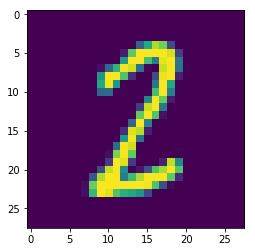

In [72]:
randix = np.random.randint(0,60000)
plt.imshow(x_train[randix])
print("Label is {}.".format(y_train[randix]))

In [73]:
x_train_f = x_train.reshape(60000,-1)

In [74]:
x_train_f.shape

(60000, 784)

In [75]:
x_test_f = x_test.reshape(-1, 28**2)

In [76]:
x_test_f.shape

(10000, 784)

In [77]:
from sklearn.preprocessing import OneHotEncoder as OHE

In [78]:
ohe = OHE(sparse = False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))

In [79]:
np.argmax(y_train_ohe[randix]) == y_train[randix]

True

Now construct a KNN classifier

In [80]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
class KNNClassifier(object):

    def fit(self,x,y,k=1,fun=lambda x: np.mean(x,axis=0)):
        """Fits a KNN regressor.
        Args:
            x (numpy array) Array of samples indexed along first axis.
            y (numpy array) Array of corresponding labels.
            k (int) the number of neighbors
            fun (function numpy array --> desired output) Function to be applied to k-nearest
              neighbors for predictions
        """
        self.x = x[:]
        self.y = y[:]
        self.k = k
        self.f = fun
        self.tree = KDTree(self.x)
        
    def predict_one(self, sample):
        """
        Run prediction on sample
        
        Args:
            new_x (numpy array) sample
        
        """
        dists = cdist(sample.reshape(1,-1),self.x)
        ix = np.argpartition(dists,self.k-1)[0,0:self.k]
        return self.f(self.y[ix])
    
    def predict(self, samples):
        """
        Run predictions on list.
        Args:
            samples (numpy array) samples
        """
        return np.array([self.predict_one(x) for x in samples])
    
    def faster_predict(self,samples):
        """
        Run faster predictions on list.
        Args:
            samples (numpy array) samples
        """
        _, ixs = self.tree.query(samples, k=self.k)
        #print(ixs)
        return np.array([self.f(self.y[ix]) for ix in ixs])
        


In [81]:
classifier = KNNClassifier()

In [82]:
classifier.fit(x_train_f, y_train_ohe, k=1)

In [83]:
preds=classifier.predict(x_test_f[:500])

Calculate accuracy on this very small subset.

In [84]:
np.mean(np.argmax(preds,axis=1)==y_test[:500])

0.96599999999999997

In [85]:
faster_preds = classifier.faster_predict(x_test_f[:500])

In [87]:
np.mean(np.argmax(faster_preds,axis=1)==y_test[:500])

0.96599999999999997

Let's time these different methods to see if the "faster_preds" is actually faster:

In [88]:
from timeit import default_timer as timer

In [89]:
start = timer()
classifier.predict(x_test_f[:500])
end = timer()
print(end-start)

111.65225832597935


In [90]:
start = timer()
classifier.faster_predict(x_test_f[:500])
end = timer()
print(end-start)

28.22454002001905


Okay now, let us try the clustering algorithm.

In [108]:
def cluster_means(x,cluster_assignments,k):
    """
    Return the new cluster means and the within cluster squared distance given the cluster assignments
    """
    cluster_counter = np.zeros((k,1))
    cluster_means = np.zeros((k, x.shape[1]))

    for cluster, pt in zip(cluster_assignments, x):
        #print(x)
        cluster_means[cluster] += pt
        cluster_counter[cluster]+=1
    cluster_means = cluster_means/cluster_counter
    
    wcss = 0.
    for cluster, pt in zip(cluster_assignments, x):
        wcss+=np.sum((pt-cluster_means[cluster])**2)
        
    return cluster_means, wcss

class KMeansCluster(object):

    
    #Fit a clustering object on a dataset x consisting of samples on each row
    #by the K-means algorithm into k clusters
    def fit(self,x,k):
        """
        Fit k-means clusterer
        
        Args:
            x (numpy array) samples
            k (int) number of clusters
        """
        num_samples, num_features = x.shape[0], x.shape[1]
        #Randomly assign clusters
        cluster_assignments = np.random.randint(0,k,num_samples)
        
        #initialize
        cluster_mus = np.zeros((k,num_features))
        
        #update
        new_cluster_mus, wcss = cluster_means(x,cluster_assignments,k)
        count = 1
        while (cluster_mus!=new_cluster_mus).any() and count < 10**3:
            count += 1
            print("Iteration {:3d}, WCSS = {:10f}".format(count,wcss),end="\r")
            cluster_mus = new_cluster_mus
            #calculate distances
            distances = cdist(x,cluster_mus, metric = 'sqeuclidean')
            np.argmin(distances, axis = 1, out = cluster_assignments)
            new_cluster_mus, wcss = cluster_means(x,cluster_assignments,k)
        self.cluster_means = cluster_means
        self.cluster_assignments = cluster_assignments
        self.x = x[:]
        self.wcss = wcss

In [110]:
clusterer = KMeansCluster()
clusterer.fit(x_train_f,10)

In [111]:
clusterer2 = KMeansCluster()
clusterer2.fit(x_train_f,10)

In [112]:
from sklearn.metrics import confusion_matrix

In [113]:
confusion_matrix(y_train, clusterer2.cluster_assignments)

array([[   7,    5, 4306,    2,  232,   79,  156,    2, 1089,   45],
       [   9,   10,    0, 3042,    6,    8,    5, 3650,    6,    6],
       [4157,   68,   44,  331,  276,  170,  132,  380,  210,  190],
       [ 173,   36,   22,   50, 3857,  955,   29,  407,  431,  171],
       [  29, 1883,    7,  210,    0,   14,  144,  154,  209, 3192],
       [   5,  163,   54,  234, 1807, 1006,   61,  149, 1570,  372],
       [  53,    3,   53,   40,   34,   16, 3788,  185, 1691,   55],
       [  40, 3771,   20,  258,    5,   15,    4,  337,   10, 1805],
       [  44,  164,   29,  274, 1028, 3514,   42,  316,  263,  177],
       [  17, 2448,   41,   86,   81,   71,    9,  255,   23, 2918]])

In [114]:
cluster_samples = clusterer2.x[clusterer2.cluster_assignments == 0]

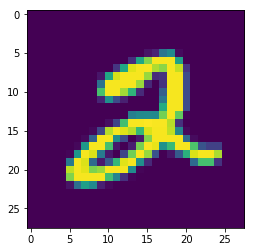

In [115]:
plt.imshow(cluster_samples[0].reshape(28,28))

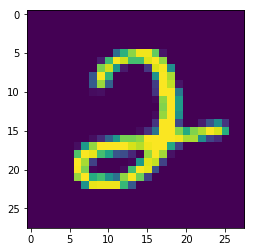

In [116]:
plt.imshow(cluster_samples[1].reshape(28,28))

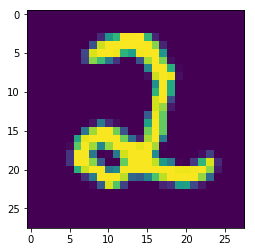

In [117]:
plt.imshow(cluster_samples[23].reshape(28,28))

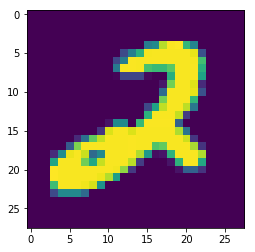

In [118]:
plt.imshow(cluster_samples[50].reshape(28,28))

In [119]:
np.mean(classifier.faster_predict(cluster_samples),axis=0)

array([ 0.00154389,  0.001985  ,  0.91685046,  0.03815615,  0.00639612,
        0.00110278,  0.01168946,  0.00882223,  0.00970446,  0.00374945])

Let us load the credit card dataset and extract a small dataframe of numerical features to test on.

In [120]:
big_df = pd.read_csv("UCI_Credit_Card.csv")

In [121]:
big_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [122]:
len(big_df)

30000

In [123]:
len(big_df.dropna())

30000

In [124]:
df = big_df.drop(labels = ['ID'], axis = 1)

In [125]:
labels = df['default.payment.next.month']
df.drop('default.payment.next.month', axis = 1, inplace = True)

In [126]:
num_samples = 25000

In [127]:
train_x, train_y = df[0:num_samples], labels[0:num_samples]

In [128]:
test_x, test_y = df[num_samples:], labels[num_samples:]

In [129]:
test_x.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
25000,410000.0,1,1,1,38,-1,-1,-1,-1,-2,...,35509.0,0.0,0.0,0.0,0.0,35509.0,0.0,0.0,0.0,0.0
25001,260000.0,1,2,2,35,0,0,0,0,0,...,297313.0,276948.0,2378.0,-2709.0,12325.0,6633.0,6889.0,1025.0,2047.0,194102.0
25002,50000.0,1,2,1,40,0,0,0,0,0,...,11353.0,12143.0,11753.0,11922.0,1200.0,4000.0,2000.0,2000.0,1000.0,1000.0
25003,360000.0,1,3,1,37,-1,-1,-1,-2,-2,...,0.0,0.0,0.0,0.0,303.0,0.0,0.0,0.0,0.0,860.0
25004,50000.0,1,3,1,49,0,0,0,0,0,...,50076.0,48995.0,19780.0,15102.0,2000.0,5000.0,2305.0,3000.0,559.0,3000.0


In [130]:
train_y.head()

0    1
1    1
2    0
3    0
4    0
Name: default.payment.next.month, dtype: int64

Now let us write our transformation function.

In [1427]:
class bin_transformer(object):
    
    def __init__(self, df, num_quantiles = 2):
        #identify list of quantiles
        self.quantiles = df.quantile(np.linspace(1./num_quantiles, 1.-1./num_quantiles,num_quantiles-1))
            
    
    def transform(self, df):
        """
        Args:
            df (pandas dataframe) : dataframe to transform
        
        Returns:
            new (pandas dataframe) : new dataframe where for every feature of the original there will be 
                num_quantiles-1 features corresponding to whether or not the original values where greater
                than or equal to the corresponding quantile.
            fns (dictionary (string,float)) returns dictionary of quantiles
                
        """
        new = pd.DataFrame()
        fns = {}
        for col_name in df.axes[1]:
            for ix, q in self.quantiles.iterrows():
                quart = q[col_name]
                new[col_name+str(ix)] = (df[col_name] >= quart)
                fn = quart
                fns[col_name+str(ix)] = [col_name, fn]
        return new, fns

In [1428]:
transformer = bin_transformer(train_x,2)

In [1429]:
train_x_t, tr_fns = transformer.transform(train_x)

In [1430]:
test_x_t, test_fns = transformer.transform(test_x)

In [1431]:
train_x_t.head()

,LIMIT_BAL0.5,SEX0.5,EDUCATION0.5,MARRIAGE0.5,AGE0.5,PAY_00.5,PAY_20.5,PAY_30.5,PAY_40.5,PAY_50.5,...,BILL_AMT30.5,BILL_AMT40.5,BILL_AMT50.5,BILL_AMT60.5,PAY_AMT10.5,PAY_AMT20.5,PAY_AMT30.5,PAY_AMT40.5,PAY_AMT50.5,PAY_AMT60.5
0,False,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,True,True,False,False,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
2,False,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
3,False,True,True,False,True,True,True,True,True,True,...,True,True,True,True,False,True,False,False,False,False
4,False,False,True,False,True,False,True,False,True,True,...,True,True,True,True,False,True,True,True,False,False


Now let us build some simple loss functions for 1d labels.

In [1432]:
def bdd_cross_entropy(pred, label):
    return np.mean(-np.sum(label*np.log(pred+10**(-8)),axis=1))

In [1433]:
def MSE(pred,label):
    return np.mean(np.sum((pred-label)**2, axis=1))

In [1434]:
def acc(pred,label):
    return np.mean(np.argmax(pred,axis=1)==np.argmax(label, axis=1))

In [1348]:
def SSE(x,y):
    return np.sum((x-y)**2)

In [ ]:
def gini(x,y):
    return 1-np.sum(np.mean(y,axis=0)**2)

Now let us define the find split function.

In [1461]:
def find_split(x, y, loss, verbose = False):
    """
    Args:
        x (dataframe) : dataframe of boolean values
        y (dataframe (1 column)) : dataframe of labeled values
        loss (function: (yvalue, dataframe of labels)-->float) : calculates loss for prediction of yvalue
            for a dataframe of true values.
        verbose (bool) : whether or not to include debugging info
    """
    min_ax = None
    N = x.shape[0]
    base_loss = loss(np.mean(y,axis=0),y)
    min_loss = base_loss

    for col_name in x.axes[1]:
        mask = x[col_name]
        num_pos = np.sum(mask)
        num_neg = N - num_pos
        if num_neg*num_pos == 0:
            continue
        pos_y = np.mean(y[mask], axis = 0)
        neg_y = np.mean(y[~mask], axis = 0)
        l = (num_pos*loss(pos_y, y[mask]) + num_neg*loss(neg_y, y[~mask]))/N
        if verbose:
            print("Column {0} split has improved loss {1}".format(col_name, base_loss-l))
        if l < min_loss:
            min_loss = l
            min_ax = col_name
    return min_ax, min_loss, base_loss-min_loss
        

One hot encode our dataset

In [1567]:
ohe = OHE(sparse = False)

In [1586]:
train_y_ohe = ohe.fit_transform(train_y.values.reshape(-1,1))

In [1587]:
train_y_ohe[0:5],train_y.values[0:5]

(array([[ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]), array([1, 1, 0, 0, 0]))

In [1570]:
test_y_ohe = ohe.transform(test_y.values.reshape(-1,1))

Test this to see if it is reasonable:

In [1571]:
find_split(train_x_t, train_y_ohe, bdd_cross_entropy, verbose = False)

('LIMIT_BAL0.5', 0.51977935310923973, 0.011049199283005851)

In [1572]:
np.mean(train_y_ohe[train_x_t['LIMIT_BAL0.5']],axis=0)

array([ 0.83723663,  0.16276337])

In [1573]:
np.mean(train_y_ohe[~train_x_t['LIMIT_BAL0.5']],axis = 0)

array([ 0.71388866,  0.28611134])

In [1574]:
np.mean(train_y_ohe,axis=0)

array([ 0.77688,  0.22312])

In [1575]:
#Slow but simple
class decision_tree(object):
    def __init__(self):
        self.f = None
    
    def fit(self, x,y,depth=5,loss=MSE, minsize = 1, quintiles = 2, verbose = False):
        #Construct default function
        mu = np.mean(y, axis=0)
        
        self.f = lambda a: mu 
        
        # Check our stopping criteria
        if(x.shape[0]<=minsize or depth == 0):
            return 
       
        # transform our data
        tr = bin_transformer(x, quintiles)
        tr_x, fns = tr.transform(x)
        split, split_loss, improvement = find_split(tr_x,y,loss)
        
        if verbose:
            print("Improvement: {}".format(improvement))
        #if no good split was found return
        if split == None:
            return
        
        # Build test function
        col_to_split = fns[split][0]
        splitter = lambda a: (a[col_to_split] >= fns[split][1])

        mask = tr_x[split]
        left = decision_tree()
        right = decision_tree()
        left.fit(x[~mask],y[~mask],depth-1,loss, minsize, quintiles)
        right.fit(x[mask],y[mask],depth-1,loss, minsize, quintiles)
        def g(z):
            if(splitter(z)):
                return right.f(z)
            else:
                return left.f(z)
        self.f = g

    def predict(self, x):
        """
        Used for bulk prediction
        """
        num_samples = x.shape[0]
        
        return np.array([self.f(x.iloc[ix,:]) for ix in range(num_samples)])
        

Test this out.

In [1576]:
dt = decision_tree()

In [ ]:
dt.fit(train_x, train_y_ohe, loss = MSE, minsize = 1, depth = 6, quintiles = 50)

In [ ]:
dt.predict(test_x.iloc[0:3,:]), test_y_ohe[0:3]

In [ ]:
preds = dt.predict(train_x)

In [ ]:
np.mean(np.argmax(preds, axis=1)==train_y)

The naive option:

In [ ]:
1-np.mean(test_y)

In [1645]:
class gradient_boosting_trees(object):
    
    def fit(self, x, y, depth = 2, quintiles = 10, num_trees  = 10):
        self.forest = [None]*num_trees
        cur_y = y[:]
        
        for ix in range(num_trees):
            self.forest[ix] = decision_tree()
            self.forest[ix].fit(x, cur_y, loss=MSE, depth = depth, quintiles = quintiles, minsize = 1)
            
            preds =  self.forest[ix].predict(x)
            cur_y = cur_y - preds
    
    def predict(self,x):
        s = 0.
        preds = [tree.predict(x) for tree in self.forest]
        for t in preds:
            s+=t
        return s
    
    

In [1680]:
forest = gradient_boosting_trees()

In [1681]:
train_y_ohe = ohe.fit_transform(train_y.values.reshape(-1,1))

In [ ]:
forest.fit(train_x, train_y_ohe, depth = 20, num_trees = 5, quintiles = 20)

In [ ]:
forest.predict(test_x.iloc[0:3,:]), test_y_ohe[0:3]

In [ ]:
for_preds = forest.predict(train_x)

In [ ]:
for_preds[0:5,:]

In [ ]:
train_y_ohe[0:3]

In [ ]:
np.mean(np.argmax(for_preds, axis=1)==train_y)

In [ ]:
for_preds = forest.predict(test_x)

In [ ]:
np.mean(np.argmax(for_preds, axis=1)==test_y)

In [ ]:
from sklearn import tree

In [ ]:
sktree = tree.DecisionTreeClassifier(max_depth=20)

In [ ]:
sktree.fit(train_x, train_y_ohe)